In [1]:
import numpy as np
import litebird_sim as lbs

def add_lbsNoise(tod, det, block_duration_s):
   
    n_block = int(block_duration_s * det.sampling_rate_hz)
    n_samp = tod.shape[1]

    dets_random = [np.random.default_rng() for _ in range(tod.shape[0])]

    for start in range(0, n_samp, n_block):
        end = min(start + n_block, n_samp)
        
        lbs.add_noise(
            tod=tod[:, start:end],
            noise_type="one_over_f",
            sampling_rate_hz=det.sampling_rate_hz,
            net_ukrts=det.net_ukrts,
            fknee_mhz=det.fknee_mhz,
            fmin_hz=det.fmin_hz,
            alpha=det.alpha,
            dets_random=dets_random,
            scale=1.0,
        )

    return tod

    
    """
    Add 1/f noise to time-ordered data (TOD) for one or more detectors, in blocks.

    This function generates correlated 1/f noise that is continuous within each block
    and independent across different observations (TOD arrays). It supports TOD arrays
    of shape (D, N), where D is the number of detectors and N is the number of time samples.

    Parameters
    ----------
    tod : numpy.ndarray
        2D array of shape (D, N) containing the time-ordered data to which noise will be added.
        The array is modified in-place.
    det : litebird_sim.DetectorInfo
        Detector information object containing noise parameters:
        - sampling_rate_hz
        - fknee_mhz
        - fmin_hz
        - alpha
        - net_ukrts
        This implementation assumes all detectors share the same parameters.
    block_duration_s : float
        Duration of each processing block in seconds. The TOD is processed
        in blocks to optimize memory usage and performance.

    Returns
    -------
    numpy.ndarray
        The input `tod` array with added 1/f noise. Modifications are done in-place.
    """

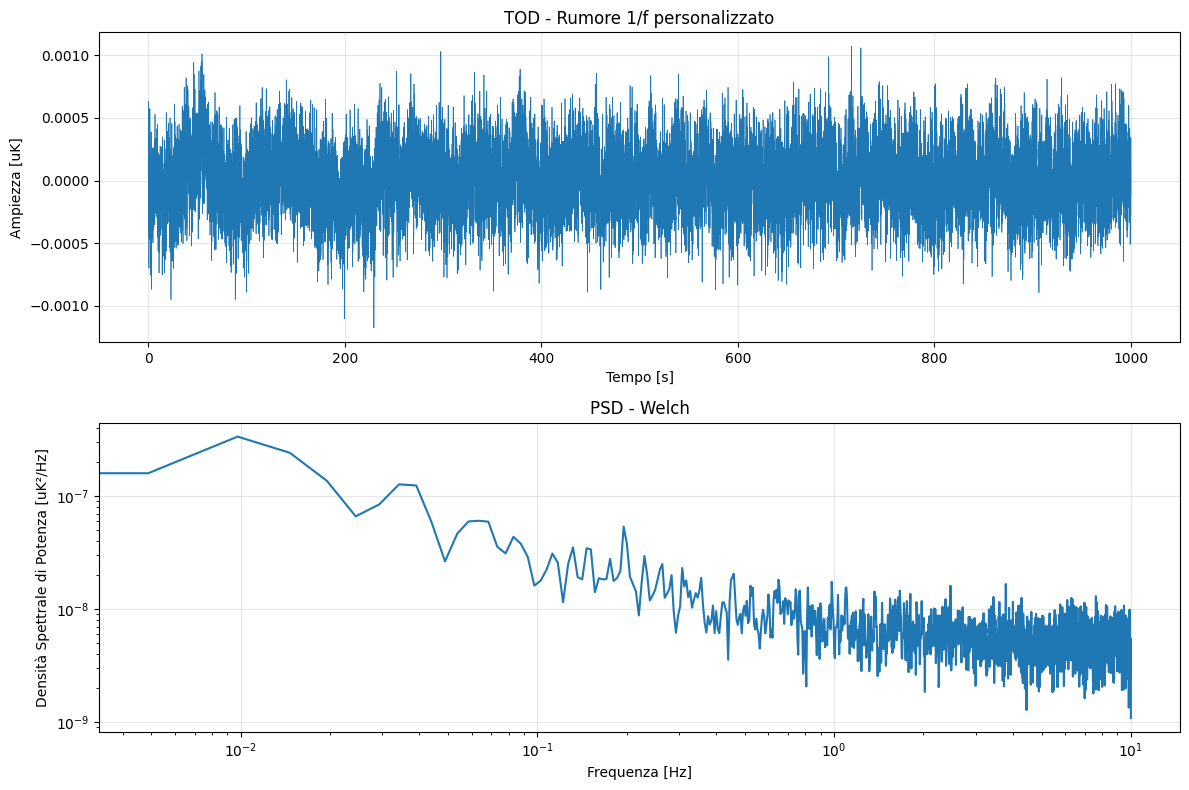

In [3]:
# MOCK DETECTOR

import litebird_sim as lbs
from astropy.time import Time
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import ducc0

start_time = 0
time_span_s = 1000.0
nside = 128

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=time_span_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) 
)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(0),
        precession_rate_hz=0,
        spin_rate_hz=1 / 60,
        start_time=start_time,
    ),
    delta_time_s=5.0,
)

sim.set_instrument(
    lbs.InstrumentInfo(
        boresight_rotangle_rad=0.0,
        spin_boresight_angle_rad=np.deg2rad(90),
        spin_rotangle_rad=np.deg2rad(75),
    )
)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.,
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.,
    fmin_hz=1e-5,
    alpha=1
)


sim.create_observations(detectors=det)

# RUMORE
tod = sim.observations[0].tod 
add_lbsNoise(tod, det, block_duration_s=100) 


# Calcolo PSD con Welch
frequencies, psd = welch(
    tod,
    fs=det.sampling_rate_hz,           
    window='hann',            
    nperseg=2**12,            
    noverlap=2**12 // 2,       
    axis=-1,                 # calcola lungo l'asse dei campioni
    scaling='density',        
)




# Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
time_axis = np.arange(tod.shape[1]) / det.sampling_rate_hz
plt.plot(time_axis, tod[0], linewidth=0.5) # prendo il detector
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza [uK]')
plt.title('TOD - Rumore 1/f personalizzato')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd[0], linewidth=1.5) # psd del primo detctor 
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Densità Spettrale di Potenza [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


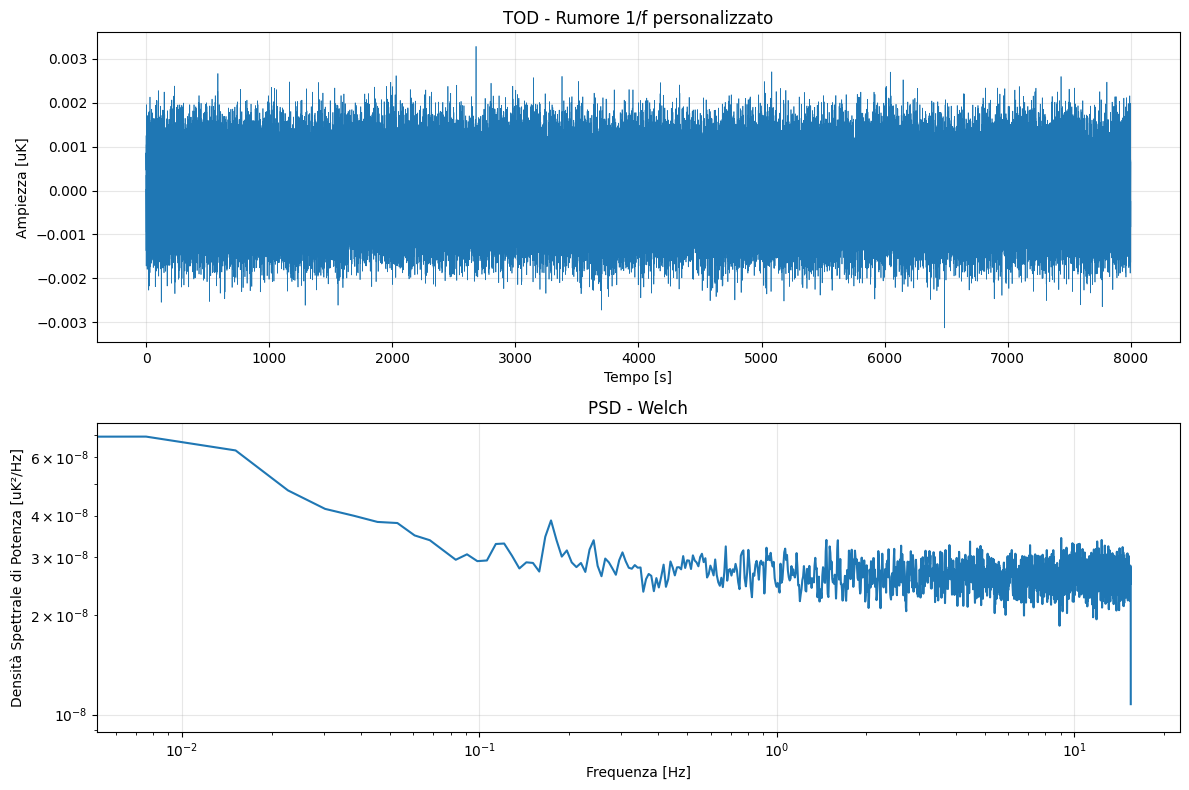


PARAMETRI DETECTOR
name                : 000_000_008_UA_040_T
sampling_rate_hz    : 31.0
bandcenter_ghz      : 40.0
net_ukrts           : 114.63
fknee_mhz           : 20.0
fmin_hz             : 1e-05
alpha               : 1.0


In [49]:
# IMO DETECTOR

import litebird_sim as lbs
from astropy.time import Time
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import ducc0

start_time = 0
time_span_s = 8000.0
nside = 128

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) # Metto imo fuori

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=time_span_s,
    random_seed=12345,
    imo=imo
)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(0),
        precession_rate_hz=0,
        spin_rate_hz=1 / 60,
        start_time=start_time,
    ),
    delta_time_s=5.0,
)

sim.set_instrument(
    lbs.InstrumentInfo(
        boresight_rotangle_rad=0.0,
        spin_boresight_angle_rad=np.deg2rad(90),
        spin_rotangle_rad=np.deg2rad(75),
    )
)

# carico dati reali detector
det = lbs.DetectorInfo.from_imo(imo, "/releases/vPTEP/satellite/LFT/L1-040/000_000_008_UA_040_T/detector_info")

sim.create_observations(detectors=det)


# RUMORE
tod = sim.observations[0].tod 
add_lbsNoise(tod, det, block_duration_s=1000) 


# Calcolo PSD con Welch
frequencies, psd = welch(
    tod,
    fs=det.sampling_rate_hz,           
    window='hann',            
    nperseg=2**12,            
    noverlap=2**12 // 2,       
    axis=-1,                 # calcola lungo l'asse dei campioni
    scaling='density',        
)




# Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
time_axis = np.arange(tod.shape[1]) / det.sampling_rate_hz
plt.plot(time_axis, tod[0], linewidth=0.5) # prendo il detector
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza [uK]')
plt.title('TOD - Rumore 1/f personalizzato')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd[0], linewidth=1.5) # psd del primo detctor 
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Densità Spettrale di Potenza [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Stampo parametri detector
print("\nPARAMETRI DETECTOR")

params = [
    "name",
    "sampling_rate_hz",
    "bandcenter_ghz",
    "net_ukrts",
    "fknee_mhz",
    "fmin_hz",
    "alpha"
]

for p in params:
    value = getattr(det, p)
    print(f"{p:20}: {value}")

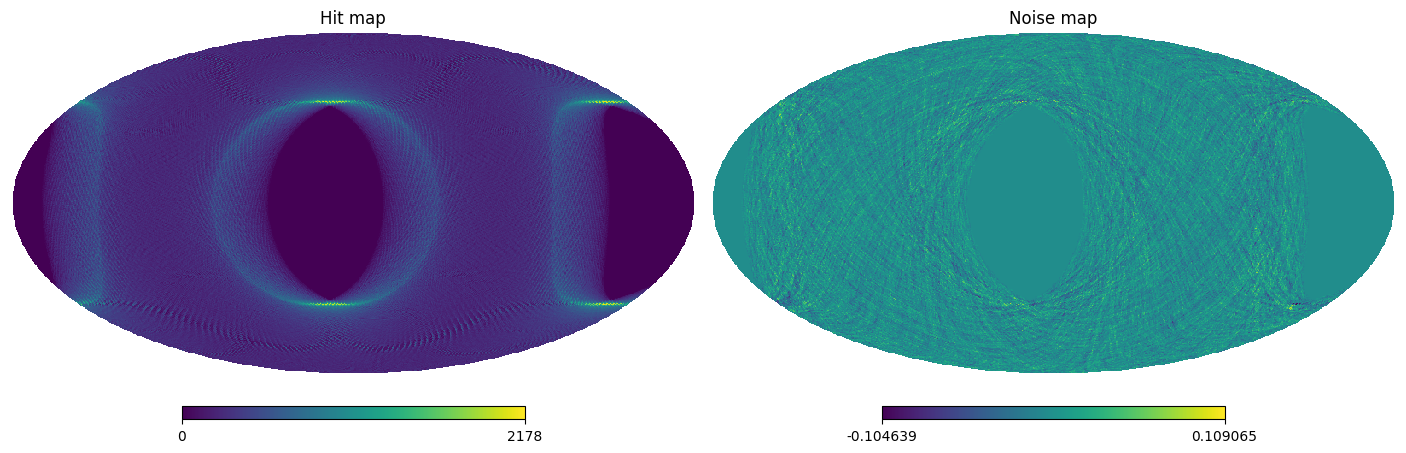

In [8]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from uuid import UUID

import litebird_sim as lbs



# SIMULATION

nside = 2**7 # map resolution (tipico di liteBIRD)
start_time = 0
duration_s = 86400*30 

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=duration_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
)



# SCANNING STRATEGY (from IMO)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy.from_imo(imo=lbs.Imo(lbs.PTEP_IMO_LOCATION), url=UUID("117fd641-a925-4eeb-9fda-f7c468682108")),
    delta_time_s=5.0
)



# INSTRUMENT & DETECTOR

instrument = lbs.InstrumentInfo(
    boresight_rotangle_rad=0.0,
    spin_boresight_angle_rad=np.deg2rad(90),
    spin_rotangle_rad=np.deg2rad(75)
)
sim.set_instrument(instrument)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.0, # ho ridotto la frequenza da 20 Hz a 5 Hz per ridurre il numero di campioni (risparmiare memoria)
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.,
    fmin_hz=1e-5,
    alpha=1
)



# OBSERVATION

sim.create_observations(detectors=det)
obs = sim.observations[0]



# POINTINGS

lbs.prepare_pointings(obs, instrument, sim.spin2ecliptic_quats)
pointings, _ = obs.get_pointings("all")

theta = pointings[0, :, 0]
phi   = pointings[0, :, 1]
pixidx = hp.ang2pix(nside, theta, phi)



# NOISE

tod = obs.tod                                   # shape (1, N)
add_lbsNoise(tod, det, block_duration_s=3600*12)



# MAP

# Hit map
m_scan = np.bincount(pixidx, minlength=hp.nside2npix(nside))

# Noise map
m_noise = np.bincount(pixidx, weights=tod[0], minlength=hp.nside2npix(nside))

# PLOT HEALPIX MAP

plt.figure(figsize=(14, 6))

hp.mollview(m_scan, title="Hit map", sub=(1,2,1))

hp.mollview(m_noise, title="Noise map", sub=(1,2,2))

plt.savefig("hp_lbs.pdf")
plt.show()